# Powering Through

**Name(s)**: Andrea González Martín & Andrés Riera Ortiz

**Website Link**: https://andiigonzalez.github.io/Power_Outage_Analysis/index.html

In [ ]:
import pandas as pd
import scipy
import numpy as np
from pathlib import Path
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import matplotlib as plt
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


## Step 1: Introduction

In [ ]:
# Open the csv file 
outages = pd.read_csv('/Users/andigonzalez/Desktop/DSC80/Power_Outage_Analysis/outages.csv') 

# Drop unncessary columns
outages.drop(['POSTAL.CODE', 'HURRICANE.NAMES', 'OUTAGE.RESTORATION.DATE', 'OUTAGE.RESTORATION.TIME', 'RES.PRICE','COM.PRICE', 'IND.PRICE', 'TOTAL.PRICE','RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN','COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUSTOMERS', 'RES.CUST.PCT', 'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA', 'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP', 'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPPCT_UC', 'POPDEN_UC', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT', 'PCT_WATER_INLAND', 'AREAPCT_URBAN','POPPCT_URBAN' ], axis=1, inplace=True)

# Save the top rows of dataframe head an html file to include in the webpage



## Step 2: Data Cleaning and Exploratory Data Analysis

### Data Cleaning

In [ ]:
# Remove leading and trailing spaces
outages.columns = outages.columns.str.strip()

#Rename U.S._STATE to STATE for ease
outages = outages.rename(columns={'U.S._STATE': 'STATE'})


# combine dates and times into a single column.
outages['OUTAGE.START'] = outages['OUTAGE.START.DATE'] + " " + outages['OUTAGE.START.TIME']
# reformat variables to datetime format
outages['OUTAGE.START'] = pd.to_datetime(outages['OUTAGE.START'], format='%Y-%m-%d %H:%M:%S')
# drop date and time columns 
outages = outages.drop(columns=['OUTAGE.START.DATE', 'OUTAGE.START.TIME'])


# Replace/Substitute values of 0 in columns OUTAGE.DURATION, DEMAND.LOSS.MW, and CUSTOMERS.AFFECTED
outages['OUTAGE.DURATION'] = outages['OUTAGE.DURATION'].replace(0, np.nan)
outages['DEMAND.LOSS.MW'] = outages['DEMAND.LOSS.MW'].replace(0, np.nan)
outages['CUSTOMERS.AFFECTED'] = outages['CUSTOMERS.AFFECTED'].replace(0, np.nan)


# Save the top rows of dataframe head an html file to include in the webpage
html_file = "/assets/images/outages_head.html"
outages.head(10).to_html(html_file, index=False)
display(outages)


### Univariate Analysis

In [394]:

# Group data by year to produce a univariate analysis of the number of outages per year. Create a bar plot with the corresponding data.
outages_by_year = outages.groupby('YEAR').count()['OBS']
outages_by_year_df = outages_by_year.reset_index()
fig = px.bar(outages_by_year_df, x='YEAR', y='OBS', title='Number of Power Outages by Year', labels={'YEAR': 'Year', 'OBS': 'Number of Outages'}, color_discrete_sequence=['orange'])

# Customize layout
fig.update_layout(
    title={
        'text': 'Number of Power Outages by Year',
        'x': 0.5,  # Center the title
        'y': 0.98,  # center the title on Y axis
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')  # Custom font for title
    },
    #font sizes for axis titles
    xaxis_title_font=dict(size=14),
    yaxis_title_font=dict(size=14), 
    xaxis=dict(tickmode='linear'),  # Ensure all years are displayed
    width=700,  
    height=300  
)

# Show the plot
fig.show()
# Save plot as HTML file
fig.write_html('assets/images/outages_by_year.html', auto_open=False)


In [395]:
# drop missing values of cause category detail

outages2 = outages.dropna(subset=['CAUSE.CATEGORY'])
# Group data by cause and count the number of occurrences
cause_counts = outages2.groupby('CAUSE.CATEGORY').size()

# Create interactive pie chart with Plotly
fig = go.Figure(data=[go.Pie(
    labels=cause_counts.index.str.capitalize(), 
    values=cause_counts.values,
    textinfo='percent+label',
    textposition='inside',
    textfont=dict(size=14, family='Arial, Helvetica, sans-serif'),
    hoverinfo='label+percent')])

# Customize layout such that text is Sans-Serif (to match website)
fig.update_layout(
    title={
        'text': 'Distribution of Power Outages by Cause from 2000 to 2016',
        'font': {'size': 20, 'family': 'Arial, Helvetica, sans-serif' } },
        font=dict(family='Arial, Helvetica, sans-serif'))

# Show the plot
fig.show()
# Save plot as HTML file
fig.write_html('assets/images/distribution_of_power_outage_cause.html', auto_open=False)

In [396]:
# Group data by state variable to produce a univariate analysis of the number of total outages per state

outages_by_state = outages.groupby('STATE').count()['OBS'].reset_index()
outages_by_state_plot = px.line(outages_by_state, x='STATE', y='OBS', title='Number of Power Outages by State from 2000 to 2016', labels={'STATE': 'State', 'OBS': 'Number of Outages'}, color_discrete_sequence=['skyblue'])

outages_by_state_plot.update_layout(
    title={
        'text': 'Number of Power Outages by State from 2000 to 2016',
        'x': 0.5,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')  # Custom font for title
    },
    xaxis_title_font=dict(size=14),  # Font size for x-axis title
    yaxis_title_font=dict(size=14),  # Font size for y-axis title
    xaxis=dict(tickmode='linear'),  # Ensure all years are displayed
    yaxis=dict(
        tickmode='array',  # Specify custom tick values
        tickvals=list(range(0, outages_by_state['OBS'].max() + 50, 50)),  # Ticks at 50 increments
        title='Number of Outages'
    ),
    width=800,  # Make the plot wider
    height=400   # Adjust height if needed
)

# Show the plot
outages_by_state_plot.show()
# Save plot as HTML file
outages_by_state_plot.write_html('assets/images/outages_by_state.html', auto_open=False)


### Bivariate Analysis

#### Bivariate Analysis #1: Interactive Map of Power Outages Experienced By Climate Regions


In [397]:

# Create a dictionary mapping regions to their states
region_states = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Southeast': ['FL', 'GA', 'AL', 'NC', 'SC', 'VA'],
    'Central': ['IL', 'MO', 'IN', 'KY', 'WV', 'OH', 'TN'],
    'Southwest': ['AZ', 'CO', 'UT', 'NM'],
    'West': ['NV', 'CA'],
    'Northwest': ['OR', 'WA', 'ID'],
    'South': ['KS', 'TX', 'OK', 'LA', 'AR', 'MS'],
    'West North Central': ['ID', 'MT', 'NE', 'ND', 'SD', 'WY'],
    'East North Central': ['MN', 'IA', 'WI', 'MI']
}

# Outages data hardcoded to set the regions on map
outages_data = {
    'Region': ['Central', 'East North Central', 'Northeast', 'Northwest', 
               'South', 'Southeast', 'Southwest', 'West', 
               'West North Central'],
    'Outages': [200, 138, 350, 132, 229, 153, 92, 217, 17]
}

# Create DataFrame
flattened_data = [(region, state) for region, states in region_states.items() for state in states]
df_regions = pd.DataFrame(flattened_data, columns=['Region', 'State'])

# Convert outages_data to a DataFrame
df_outages = pd.DataFrame(outages_data)

# Merge the regions DataFrame with the outages data
merged_df = df_regions.merge(df_outages, on='Region', how='left')
region_centers = {
    'Northeast': {'lat': 42.0, 'lon': -72.0},
    'Southeast': {'lat': 33.0, 'lon': -84.0},
    'Central': {'lat': 39.0, 'lon': -88.0},
    'Southwest': {'lat': 36.0, 'lon': -108.0},
    'West': {'lat': 37.0, 'lon': -119.0},
    'Northwest': {'lat': 45.0, 'lon': -120.0},
    'South': {'lat': 33.0, 'lon': -97.0},
    'West North Central': {'lat': 45.0, 'lon': -105.0},
    'East North Central': {'lat': 43.0, 'lon': -89.0}
}

# Create a base choropleth map
fig = px.choropleth(
    merged_df,
    locations="State",                # The column with state abbreviations
    locationmode="USA-states",        # Map mode for US states
    color="Outages",                  # Color by the total outages in the region
    hover_name="Region",              # Display the region name on hover
    title="Regional Outages in the USA",
    scope="usa",                      # set map to cover only USA
    color_continuous_scale=px.colors.sequential.Plasma
)



# Update layout to ensure sans-serif font for the plot text
fig.update_layout(
    font=dict(family="sans-serif")  # Set the font family for the whole plot to sans-serif
)

# Show the map
fig.show()

# Save plot as HTML file
fig.write_html('assets/images/outages_by_region_map.html', auto_open=False)

#### Bivariate Analysis #2: Stacked Bar Plot of Quantifying the Number of Power Outages and the Cause by Climate Region


In [398]:
import plotly.io as pio

# Create the grouped DataFrame for the plot
a = outages.groupby(['CLIMATE.REGION', 'CAUSE.CATEGORY']).count()['OBS']
df = a.reset_index()
df['CAUSE.CATEGORY'] = df['CAUSE.CATEGORY'].str.capitalize()
stacked_plot = px.bar(
    df,
    x='CLIMATE.REGION',
    y='OBS',
    color='CAUSE.CATEGORY'
)

# Update the layout of the plot
stacked_plot.update_layout(
    font=dict(family='Sans-serif'),
    title={
        'text': 'Number of Outages and their Cause Category per Region',
        'x': 0.4,  # Center the title horizontally
        'y': 0.98,  # Adjust vertical positioning of the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    xaxis_title='Climate Region',  # Title for the x-axis
    yaxis_title='Number of Outages',  # Title for the y-axis
    xaxis=dict(
        title_font=dict(size=14),  # Font size for x-axis title
        tickmode='linear'
    ),
    yaxis=dict(
        title_font=dict(size=14)  # Font size for y-axis title
    ),
    legend_title_text='Cause Category',  # Legend title
    legend=dict(
        title_font=dict(size=14),  # Font size for legend title
        font=dict(size=12)  # Font size for legend items
    ),
    width=800,  # Adjust the width of the plot
    height=400   # Adjust the height of the plot
)

# Show the plot
stacked_plot.show()

# Save the plot as an HTML file
stacked_plot.write_html(stacked_plot, file='assets/images/bivariate_stacked_barplot.html', auto_open=False)


TypeError: write_html() got multiple values for argument 'file'

#### Bivariate Analysis #3: Stacked Bar Plot of Quantifying the Number of Power Outages and the Cause by State


In [399]:
import plotly.io as pio

# Create the grouped DataFrame for the plot
outage_causes_by_State = outages.groupby(['STATE', 'CAUSE.CATEGORY']).count()['OBS']
state_causes= outage_causes_by_State.reset_index()
state_causes['CAUSE.CATEGORY'] = state_causes['CAUSE.CATEGORY'].str.capitalize()
stacked_plot_state_cause = px.bar(
    state_causes,
    x='STATE',
    y='OBS',
    color='CAUSE.CATEGORY'
)

# Update the layout of the plot
stacked_plot_state_cause.update_layout(
    font=dict(family='Sans-serif'),
    title={
        'text': 'Number of Outages and their Cause Category per State',
        'x': 0.4,  # Center the title horizontally
        'y': 0.98,  # Adjust vertical positioning of the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    xaxis_title='State',  # Title for the x-axis
    yaxis_title='Number of Outages',  # Title for the y-axis
    xaxis=dict(
        title_font=dict(size=14),  # Font size for x-axis title
        tickmode='linear'
    ),
    yaxis=dict(
        title_font=dict(size=14)  # Font size for y-axis title
    ),
    legend_title_text='Cause Category',  # Legend title
    legend=dict(
        title_font=dict(size=14),  # Font size for legend title
        font=dict(size=12)  # Font size for legend items
    ),
    width=800,  # Adjust the width of the plot
    height=400   # Adjust the height of the plot
)

# Show the plot
stacked_plot_state_cause.show()

# Save the plot as an HTML file
stacked_plot_state_cause.write_html('assets/images/bivariate_stacked_barplot_by_state.html', auto_open=False)


### Aggregate Variables

#### Pivot Table #1:
1. Grouped data by `CLIMATE.REGION`, `YEAR`, and `CAUSE.CATEGORY` to see how each of the climate region's vulnerability to specific causes and the number of outages they have experienced per cause per year. 

2. Created a Pivot Table with `pd.pivot_table()` using the dataframe of grouped values we created. We also replaced missing values with 0 for readability. 

3. Added a column called `Total Outages` to calcualte the total outages per climate region per year


In [400]:
# Group data by climate region, Year and Cause Category of the Power outage. Select Obs as observed variable

b = outages.groupby(['YEAR', 'CLIMATE.REGION', 'CAUSE.CATEGORY']).count()['OBS'] 
df2 = b.reset_index() # reset index
df2['CAUSE.CATEGORY'] = df2['CAUSE.CATEGORY'].str.capitalize() # Capitalize the Cause categories for earier visualization and aesthetic

# Create a piuvot table
pivot_table = pd.pivot_table(
    df2,
    values='OBS',
    index=['YEAR', 'CLIMATE.REGION'], # select the Multindex for the pivot table
    columns='CAUSE.CATEGORY',
    aggfunc='sum',  # Aggregation function to calculate number of outages with the same cause within each climate region and year
    fill_value=0    # Replace NaN with 0 for readability
)


# Add an extra column that computed the total jumber of outages per year per climate region
pivot_table['Total Outages'] = pivot_table.sum(axis=1)

# Convert the pivot table to HTML and save it into my assets/images folder
pivot_table.to_html('assets/images/pivot_table_outages.html', border=1, col_space=150) 



#### Pivot Table #2: Total Number of Outages by Month Occurance and Cause
This pivot table is to understand the distribution of outages over the months in a year and also the relationship between certain outages causes and the month they occured in . 

1. Grouped data by `CAUSE.CATEGORY`, `CAUSE.CATEGORY.DETAIL`, and `MONTH` to see if each state's yearly consumption of electricty and number of outages have a trend or not. 

2. Created a Pivot Table with `pd.pivot_table()` using the dataframe of grouped values we created. We also replaced missing values with 0 for readability and used the aggregate function `sum` to compute the number of outages that occured in a specific month due to the same cause category and category detail.

3. Added a column called `Total Outages` to calcualte the total outages per climate region per year

In [401]:
# Group data by cause category, montgh and cause category detail. Select Obs as observed variable

a = outages.groupby(['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'MONTH']).count()['OBS']
df = a.reset_index()

# Capitalize the Cause categories for earier visualization and aesthetic
df['CAUSE.CATEGORY'] = df['CAUSE.CATEGORY'].str.capitalize() 

# Create a piuvot table
# For easier understanding, fill in missing values (NaN) as 0
pivot_table2 = df.pivot_table(
    index=['CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'],  # select the Multindex for the pivot table
    columns='MONTH',
    values='OBS',
    fill_value=0,   # Replace NaN with 0 for readability
    aggfunc='sum'  # Sum if there are multiple entries per group
)

# Deleted any rows that were all 0's for visual interpretation
pivot_table2 = pivot_table2.loc[(pivot_table2 != 0).any(axis=1)] 

# Converted numerical values of months into abbreviations for the month. ie. 1.0 = 'Jan'
pivot_table2.columns = pd.to_datetime(pivot_table2.columns, format='%m').strftime('%b') 

# Add a 'Total' row for the total outages per month (by summing columns)
pivot_table2['Total'] = pivot_table2.sum(axis=1)

pivot_table2 = pivot_table2.rename_axis(index={"CAUSE.CATEGORY": "Cause Category", "CAUSE.CATEGORY.DETAIL": "Cause Category Detail"}, columns="Month")

# Convert the pivot table to HTML and save it into my assets/images folder
pivot_table2.to_html('assets/images/outages_by_month.html', border=1, col_space=100) # Convert the pivot table to HTML and save it into my assets/images folder


## Step 3: Assessment of Missingness

### Missingness Dependency: `CAUSE.CATEGORY.DETAIL` (non-trivial missingness column)


In [402]:
# Checked how many missing values in each Column
missing_info = outages.isna().sum()
display(missing_info.sort(ascending=False))

AttributeError: 'Series' object has no attribute 'sort'

In [403]:

def permutation_test_nmar(df, feature_column, target_column, num_permutations=1000):
    
    missing = df[df[target_column].isna()]
    non_missing = df[df[target_column].notna()]

    # Compute observed TVD
    observed_tvd = np.abs(missing[feature_column].value_counts(normalize=True) -
                          non_missing[feature_column].value_counts(normalize=True)).sum() / 2

    # Compute TVDs for permutations
    tvd_null = []
    combined = df.copy()
    for _ in range(num_permutations):
        combined[target_column] = np.random.permutation(combined[target_column])
        perm_missing = combined[combined[target_column].isna()]
        perm_non_missing = combined[combined[target_column].notna()]
        tvd_null.append(np.abs(perm_missing[feature_column].value_counts(normalize=True) -
                               perm_non_missing[feature_column].value_counts(normalize=True)).sum() / 2)

    # Calculate p-value (proportion of null TVDs >= observed TVD)
    p_value = np.sum(np.array(tvd_null) >= observed_tvd) / num_permutations

    print(f"p-value: {p_value}")
    print(f"observed_tvd: {observed_tvd}")

    return observed_tvd, p_value, tvd_null

# Chosen column with non-trivial missingness
column_to_analyze =  'OUTAGE.DURATION'

# Remove the column to analyze from the list of non-numeric columns
columns_to_test = ['YEAR', 'MONTH', 'STATE', 'NERC.REGION', 'CLIMATE.REGION', 
                   'CAUSE.CATEGORY', 'CLIMATE.CATEGORY', 'TOTAL.SALES', 'CLIMATE.REGION', 'ANOMALY.LEVEL', 'POPULATION', 'CUSTOMERS.AFFECTED'] 
for column in columns_to_test:
    observed_tvd, p_value, tvd_null = permutation_test_nmar(outages, column, column_to_analyze)
        # If the p-value is less than 0.05, we reject the null hypothesis
    if p_value < 0.05:
        print(f'The missingness of {column_to_analyze} depends on {column}. p-value:{p_value}, observed statistic{observed_tvd}')
    else:
        print(f'The missingness of {column_to_analyze} does not depend on {column} p-value:{p_value}, observed statistic{observed_tvd}')

p-value: 0.0
observed_tvd: 0.38740217116889675
The missingness of OUTAGE.DURATION depends on YEAR. p-value:0.0, observed statistic0.38740217116889675
p-value: 0.183
observed_tvd: 0.14349520687596456
The missingness of OUTAGE.DURATION does not depend on MONTH p-value:0.183, observed statistic0.14349520687596456
p-value: 0.0
observed_tvd: 0.2762822940334933
The missingness of OUTAGE.DURATION depends on STATE. p-value:0.0, observed statistic0.2762822940334933
p-value: 0.055
observed_tvd: 0.13689198855507867
The missingness of OUTAGE.DURATION does not depend on NERC.REGION p-value:0.055, observed statistic0.13689198855507867
p-value: 0.0
observed_tvd: 0.27010714950413445
The missingness of OUTAGE.DURATION depends on CLIMATE.REGION. p-value:0.0, observed statistic0.27010714950413445
p-value: 0.0
observed_tvd: 0.4440902970630312
The missingness of OUTAGE.DURATION depends on CAUSE.CATEGORY. p-value:0.0, observed statistic0.4440902970630312
p-value: 0.058
observed_tvd: 0.09413335135683149
The 

#### Missingness Analysis #1: 
**Colums:** `OUTAGE.DURATION` & `MONTH`

In [404]:
import plotly.express as px
import plotly.io as pio
import pandas as pd

# Create subsets for missing and non-missing OUTAGE.DURATION
missing_duration = outages[outages['OUTAGE.DURATION'].isna()]
non_missing_duration = outages[outages['OUTAGE.DURATION'].notna()]

# Compute normalized value counts for 'MONTH'
missing_counts = missing_duration['MONTH'].value_counts(normalize=True).reset_index()
missing_counts.columns = ['MONTH', 'Missing Outage Duration']

non_missing_counts = non_missing_duration['MONTH'].value_counts(normalize=True).reset_index()
non_missing_counts.columns = ['MONTH', 'Non-Missing Outage Duration']

# Merge both counts into a single DataFrame for plotting
month_counts = pd.merge(missing_counts, non_missing_counts, on='MONTH', how='outer').fillna(0)

# Melt the dataframe to convert it into a long format
month_counts = pd.melt(month_counts, id_vars='MONTH', value_vars=['Missing Outage Duration', 'Non-Missing Outage Duration'])

# Plot using Plotly
fig = px.bar(month_counts,  
             x='MONTH',  
             y='value',  
             color='variable',  
             labels={'MONTH': 'Month',  
                     'value': 'Relative Frequency',  
                     'variable': 'Outage Duration Status'},  
             barmode='group')  

# Customize layout
fig.update_layout(  
   title={  
      'text': 'Distribution of Outage Duration Missingness by Month',  
      'x': 0.4,  # Center the title  
      'y': 0.98,  # Add padding above the plot  
      'xanchor': 'center',  
      'yanchor': 'top',  
      'font': dict(family='Serif', size=18, color='black')},  
   legend={  
      'font': dict(family='Serif', size=12, color='black')},  
   xaxis=dict(
       title='Month',
       range=[0, 13] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       tickvals=list(range(1,13)),
       ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    ),
    yaxis=dict(
       title='Relative Frequency',
       range=[0, 0.15] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       ),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400 )  

# Show the plot
fig.show()

# Optionally, save the figure
fig.write_html('assets/images/OutageDuration_Month_Missingness.html', auto_open=False)



In [405]:
simulated2 = outages.copy()

observed_tvd, p_value, tvd_null = permutation_test_nmar(simulated2, 'MONTH', 'OUTAGE.DURATION')  
observed_tvd, p_value, tvd_null

null_hist = go.Histogram(
    x=tvd_null,
    nbinsx=50,
    opacity=0.5,
    name='Null distribution',
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
)


# Add the observed TVD as a vertical line
observed_line = go.Scatter(
    x=[observed_tvd, observed_tvd],
    y=[0, max(np.histogram(tvd_null, bins=10)[0])],  
    mode='lines',
    name='Observed TVD',
    line=dict(color='red', width=2)
)

# Create the layout with custom x and y axis ranges and apply sans-serif font
layout = go.Layout(
    title={
        'text': 'Distribution of Outage Duration Missingness Dependence on Month',
        'x': 0.45,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')},
    legend = {
        'font': dict(family='Serif', size=12, color='black') },
    xaxis=dict(
       title='TVD Value',
       range=[min(tvd_null), 0.35] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.05,
    ),
    yaxis=dict(
        title='Density',
        range=[0, 21],
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=2,
        ),
    barmode='overlay',
    showlegend=True,
    font=dict(family='Arial, sans-serif'),
    width=700,  # Make the plot wider
    height=400)



# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/OutageDuration_vs_Month.html', auto_open=False)


p-value: 0.184
observed_tvd: 0.14349520687596456


#### Missingness Analysis #2: 
**Colums:**

In [406]:
simulated2 = outages[['YEAR', 'STATE', 'TOTAL.SALES', 'MONTH', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'CAUSE.CATEGORY.DETAIL']]


observed_tvd, p_value, tvd_null = permutation_test_nmar(simulated2, 'YEAR', 'OUTAGE.DURATION')  
observed_tvd, p_value, tvd_null

null_hist = go.Histogram(
    x=tvd_null,
    nbinsx=50,
    opacity=0.5,
    name='Null distribution',
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
    )


# Add the observed TVD as a vertical line
observed_line = go.Scatter(
    x=[observed_tvd, observed_tvd],
    y=[0, 18],  
    mode='lines',
    name='Observed TVD',
    line=dict(color='red', width=2)
    )

# Create the layout with custom x and y axis ranges and apply sans-serif font
layout = go.Layout(
    title={
        'text': 'Distribution of Outage Duration Missingness Dependence on Year',
        'x': 0.43,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')},
    legend = {
        'font': dict(family='Serif', size=12, color='black') },
    xaxis=dict(
       title='TVD Value',
       range=[min(tvd_null), 0.43] ,
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.05,
    ),
    yaxis=dict(
        title='Density',
        range=[0, 20],
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=2,
        ),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400  
)  



# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/OutageDuration_vs_Year.html', auto_open=False)


p-value: 0.0
observed_tvd: 0.38740217116889675


In [407]:
import plotly.express as px
import plotly.io as pio
import pandas as pd

# Create subsets for missing and non-missing OUTAGE.DURATION
missing_duration = outages[outages['OUTAGE.DURATION'].isna()]
non_missing_duration = outages[outages['OUTAGE.DURATION'].notna()]

# Compute normalized value counts for 'MONTH'
missing_counts = missing_duration['YEAR'].value_counts(normalize=True).reset_index()
missing_counts.columns = ['YEAR', 'Missing Outage Duration']

non_missing_counts = non_missing_duration['YEAR'].value_counts(normalize=True).reset_index()
non_missing_counts.columns = ['YEAR', 'Non-Missing Outage Duration']

# Merge both counts into a single DataFrame for plotting
month_counts = pd.merge(missing_counts, non_missing_counts, on='YEAR', how='outer').fillna(0)

# Melt the dataframe to convert it into a long format
month_counts = pd.melt(month_counts, id_vars='YEAR', value_vars=['Missing Outage Duration', 'Non-Missing Outage Duration'])

# Plot using Plotly
fig = px.bar(month_counts,  
             x='YEAR',  
             y='value',  
             color='variable',  
             labels={'Year': 'Year',  
                     'value': 'Relative Frequency',  
                     'variable': 'Outage Duration Status'},  
             barmode='group')  
years = month_counts['YEAR'].unique()
# Customize layout
fig.update_layout(  
   title={  
      'text': 'Distribution of Outage Duration Missingness by Year',  
      'x': 0.4,  # Center the title  
      'y': 0.98,  # Add padding above the plot  
      'xanchor': 'center',  
      'yanchor': 'top',  
      'font': dict(family='Serif', size=18, color='black')},  
   legend={  
      'font': dict(family='Serif', size=12, color='black')},  
   xaxis=dict(
       title='Year',
       title_font=dict(size=14, family='Serif'),
       tickangle=-90,
       tickfont=dict(family='Serif', size=13),
       tickmode='array',  # Use custom tick values
       tickvals=years,  # Set the tick positions to the years
       ticktext=years  # Set the tick labels to the years
       ),

   yaxis=dict(
       title='Proportion',
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14)),
   showlegend=True,  
   width=700,  # Make the plot wider  
   height=400  
)  

# Show the plot
fig.show()

# Optionally, save the figure
fig.write_html('assets/images/OutageDuration_Year_Missingness.html', auto_open=False)



## Step 4: Hypothesis Testing

### Layout

**Null Hypothesis**: The number of power outages is uniformly distributed across all months of the year

**Alternative Hypothesis**: The number of outages is not uniformly distributed across all months of the year

**Test Statistic**: K2 Statistic

**Significance Level**: 5%


In [408]:


outages2 = outages.copy()

cold_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'cold']['OUTAGE.DURATION'].dropna()
warm_durations = outages2[outages2['CLIMATE.CATEGORY'] == 'warm']['OUTAGE.DURATION'].dropna()

combined_durations = np.concatenate([cold_durations, warm_durations])
n_cold = len(cold_durations)

observed_ks_statistic, _ = kstest(cold_durations, warm_durations)

num_repetitions = 10000
permutation_ks_statistics = []

for _ in range(num_repetitions):
    np.random.shuffle(combined_durations)
    
    permuted_cold = combined_durations[:n_cold]
    permuted_warm = combined_durations[n_cold:]
    
    ks_stat, _ = kstest(permuted_cold, permuted_warm)
    permutation_ks_statistics.append(ks_stat)

p_value_permutation = np.mean(np.array(permutation_ks_statistics) >= observed_ks_statistic)

conclusion = ''
if p_value_permutation>0.05:
    conclusion = 'fail to reject'
else:
    conclusion = 'reject'


print("Observed K-S Statistic:", observed_ks_statistic)
print("Permutation-based P-Value:", p_value_permutation)
print(f"We {conclusion} the null hypothesis")

# Create histogram of permutated distibutions

null_hist = go.Histogram(
    x=permutation_ks_statistics,
    nbinsx=50,
    opacity=0.5,
    histnorm='probability density',  # Normalize the histogram
    marker=dict(color='rgba(0, 100, 200, 0.7)')
)

# Add the observed K-S statistic as a vertical line
observed_line = go.Scatter(
    x=[observed_ks_statistic, observed_ks_statistic],
    y=[0, 1300],  
    mode='lines',
    name='Observed K-S Statistic',
    line=dict(color='red', width=2)
)

# Create layout for the plot
layout = go.Layout(
    title={
        'text': 'Distribution of Permutation K-S Statistics',
        'x': 0.45,  # Center the title
        'y': 0.98,  # Add padding above the plot
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    legend={
        'font': dict(family='Serif', size=12, color='black')
    },
    xaxis=dict(
       title='K-S Statistic',
       range=[0, 0.20],  # Adjust range to fit your data
       title_font=dict(size=14, family='Serif'),
       tickfont=dict(family='Serif', size=14),
       dtick=0.02,
    ),
    yaxis=dict(
        title='Frequency',
        range=[0, 30],  # Adjust range based on your data
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=14),
        dtick=5,
    ),
    barmode='overlay',
    showlegend=True,
    font=dict(family='Arial, sans-serif'),
    width=700,  # Make the plot wider
    height=400
)

# Create the figure and plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()
fig.write_html('assets/images/HypothesisPlot.html', auto_open=False)

Observed K-S Statistic: 0.10397502182233263
Permutation-based P-Value: 0.0475
We reject the null hypothesis


## Step 6: Baseline Model

In [409]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, classification_report,  confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
data = outages2
data['Weather_Related'] = data['CAUSE.CATEGORY'].apply(lambda x: 1 if x == 'severe weather' else 0)
# Select relevant columns

data = data.drop(columns={'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'})

target = 'Weather_Related'
features = ["CLIMATE.CATEGORY", "ANOMALY.LEVEL", "CLIMATE.REGION"]
target = 'Weather_Related'

numeric_features = ["ANOMALY.LEVEL"]
numeric_transformer = StandardScaler()

categorical_features = ["CLIMATE.CATEGORY", "CLIMATE.REGION"]
categorical_transformer = OneHotEncoder(drop='first',handle_unknown="ignore")


data_cleaned = data.dropna(subset=[target]+features)
X = data_cleaned[features].dropna()
y = data_cleaned[target].dropna()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine preprocessors in a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Create a pipeline with the preprocessor and a random forest regressor
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
cv = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
report = classification_report(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
print("Base Model F1 Score:", final_f1)
print(f"Cross Validation: {cv}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Base Model F1 Score: 0.6827586206896552
Cross Validation: [0.74 0.72 0.72 0.74 0.7  0.73 0.73 0.68 0.68 0.69]

Confusion Matrix:
 [[113  59]
 [ 33  99]]


## Step 7: Final Model

In [414]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

# Load the dataset
data = outages2
data['Weather_Related'] = data['CAUSE.CATEGORY'].apply(lambda x: 1 if x == 'severe weather' else 0)
data = data.drop(columns={'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL'})

target = 'Weather_Related'

# Feature engineering: Adding new features
data["URBAN_DENSITY_NORMALIZED"] = data["POPDEN_URBAN"] / data["POPULATION"]
data["AVG_MW_PER_PERSON"] = data["TOTAL.SALES"]/data['POPULATION']
data['MONTH_SIN'] = np.sin(2 * np.pi * data['MONTH'] / 12).dropna()  # Sine transformation
data['MONTH_COS'] = np.cos(2 * np.pi * data['MONTH'] / 12).dropna()  # Cosine transformation



# Define features
features = [
    "POPULATION", "CLIMATE.REGION", "CLIMATE.CATEGORY", "ANOMALY.LEVEL", "URBAN_DENSITY_NORMALIZED", "AVG_MW_PER_PERSON", "MONTH_SIN", "MONTH_COS", 'YEAR']


data_cleaned = data.dropna(subset=[target]+features)
X = data_cleaned[features].dropna()
y = data_cleaned[target].dropna()


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ["POPULATION", "ANOMALY.LEVEL", "URBAN_DENSITY_NORMALIZED", "AVG_MW_PER_PERSON","MONTH_SIN", "MONTH_COS",'YEAR']
categorical_features = ["CLIMATE.REGION", "CLIMATE.CATEGORY"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Define the model pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))  # Changed to classifier
])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__max_depth": [10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__max_features": [None, 'sqrt', 'log2'],
    "classifier__bootstrap": [True, False]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1", verbose=1)  # Changed scoring to 'f1'

# Fit the model with GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and corresponding model
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Evaluate the final model
y_pred = best_model.predict(X_test)
final_f1 = f1_score(y_test, y_pred)

# Feature importance visualization (only for RandomForest)
rf_model = best_model.named_steps["classifier"]
feature_names = numeric_features + list(best_model.named_steps["preprocessor"].transformers_[1][1].get_feature_names_out())

# Plot feature importances
importances = rf_model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

fig = px.bar(
    x=np.array(feature_names)[sorted_indices], 
    y=importances[sorted_indices], 
    labels={'x': 'Feature', 'y': 'Importance'},
    title="Feature Importance"
)

# Update layout for the title, font, and axis labels
fig.update_layout(
    font=dict(family='Sans-serif', size=14),
    title={
        'text': 'Feature Importance',
        'x': 0.5,  # Center the title horizontally
        'y': 0.98,  # Adjust vertical positioning of the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    xaxis_title='Feature',  # Title for the x-axis
    yaxis_title='Importance',  # Title for the y-axis
    xaxis=dict(
        title_font=dict(size=14),  # Font size for x-axis title
        tickmode='linear'
    ),
    yaxis=dict(
        title_font=dict(size=14)  # Font size for y-axis title
    ),
    width=800,  # Adjust the width of the plot
    height=400   # Adjust the height of the plot
)

# Show the plot
fig.show()
fig.write_html('assets/images/FeatureImportance.html', auto_open=False)

print("Best Hyperparameters:", best_params)
print("Final Model F1 Score:", final_f1)
cv = cross_val_score(pipeline, X_train, y_train, cv=10, scoring='f1')
report = classification_report(y_test, y_pred)
print(f"Cross Validation: {cv}")
print(f"Classification Report:\n {report}")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred)) 


Fitting 5 folds for each of 162 candidates, totalling 810 fits


/Users/andigonzalez/miniforge3/envs/dsc80/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning:

invalid value encountered in cast



Best Hyperparameters: {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'sqrt', 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}
Final Model F1 Score: 0.7490909090909091
Cross Validation: [0.8  0.75 0.78 0.78 0.77 0.81 0.85 0.73 0.8  0.77]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.76      0.79       170
           1       0.72      0.78      0.75       132

    accuracy                           0.77       302
   macro avg       0.77      0.77      0.77       302
weighted avg       0.78      0.77      0.77       302


Confusion Matrix:
 [[130  40]
 [ 29 103]]


## Step 8: Fairness Analysis

In [415]:
from sklearn.metrics import precision_score
import numpy as np

# Divide the test set into urban and rural groups based on URBAN_DENSITY_NORMALIZED
urban_median = X_test["URBAN_DENSITY_NORMALIZED"].median()
urban_group = X_test[X_test["URBAN_DENSITY_NORMALIZED"] > urban_median]
rural_group = X_test[X_test["URBAN_DENSITY_NORMALIZED"] <= urban_median]

# Get corresponding true labels and predictions
y_test_urban = y_test[urban_group.index]
y_test_rural = y_test[rural_group.index]
y_pred_urban = best_model.predict(urban_group)
y_pred_rural = best_model.predict(rural_group)

# Compute observed precision
precision_urban = precision_score(y_test_urban, y_pred_urban)
precision_rural = precision_score(y_test_rural, y_pred_rural)
observed_diff = abs(precision_urban - precision_rural)

# Permutation test
n_permutations = 10000
combined_labels = np.concatenate([y_test_urban, y_test_rural])
permutation_statistic = []

for _ in range(n_permutations):
    np.random.shuffle(combined_labels)
    permuted_urban = combined_labels[:len(y_test_urban)]
    permuted_rural = combined_labels[len(y_test_urban):]
    perm_urban_pred = best_model.predict(urban_group)
    perm_rural_pred = best_model.predict(rural_group)
    perm_urban_precision = precision_score(permuted_urban, perm_urban_pred)
    perm_rural_precision = precision_score(permuted_rural, perm_rural_pred)
    perm_diff = abs(perm_urban_precision - perm_rural_precision)
    permutation_statistic.append(perm_diff)

# Compute p-value
p_value = np.mean(np.array(observed_statistic) >= observed_diff)

# Print results
print(f"Observed Precision Urban: {precision_urban}")
print(f"Observed Precision Rural: {precision_rural}")
print(f"Observed Difference: {observed_diff}")
print(f"P-value: {p_value}")

permutation_statistic = permutation_statistic  # Array of permuted test statistics
observed_diff = observed_diff  # Observed difference value

# Hostogram created
null_hist = go.Histogram(
    x=permutation_statistic,
    nbinsx=30,
    name="Permutation Test Statistic",
    marker=dict(color="blue", opacity=0.6),
    histnorm='probability density'  # Histogram normalized so probability adds up to 1
)

# Observed statistic
observed_line = go.Scatter(
    x=[observed_diff, observed_diff],
    y=[0, 14],  # Adjust y-axis to reflect normalized percentages
    mode='lines',
    line=dict(color="red", dash="dash"),
    name="Observed Difference"
)

# Define the layout to keep it consistent with the rest of the graphs in the report
layout = go.Layout(
    title={
        'text': 'Permutation Test for Fairness',
        'x': 0.4,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': dict(family='Serif', size=18, color='black')
    },
    legend={
        'font': dict(family='Serif', size=12, color='black')
    },
    xaxis=dict(
        title='Difference in Precision',
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=12),
        range=[0, 0.3] 
    ),
    yaxis=dict(
        title='Probability Density',
        title_font=dict(size=14, family='Serif'),
        tickfont=dict(family='Serif', size=12),
        range=[0, 16],
    ),
    barmode='overlay',
    showlegend=True,
    font=dict(family='Arial, sans-serif'),
    width=700,
    height=400,
    paper_bgcolor="white", 
    plot_bgcolor="whitesmoke"
)

# Show the plot
fig = go.Figure(data=[null_hist, observed_line], layout=layout)
fig.show()

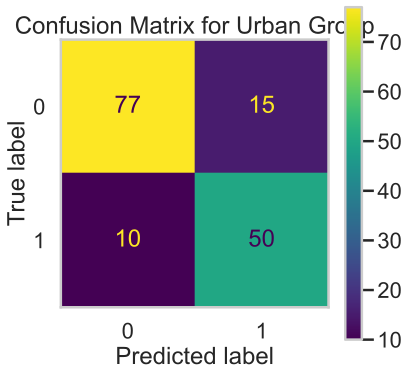

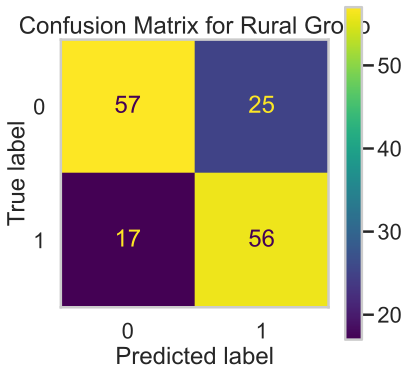

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Divide the test set into urban and rural groups based on URBAN_DENSITY_NORMALIZED
urban_median = X_test["URBAN_DENSITY_NORMALIZED"].median()
urban_group = X_test[X_test["URBAN_DENSITY_NORMALIZED"] > urban_median]
rural_group = X_test[X_test["URBAN_DENSITY_NORMALIZED"] <= urban_median]

# Get corresponding true labels and predictions
y_test_urban = y_test[urban_group.index]
y_test_rural = y_test[rural_group.index]
y_pred_urban = best_model.predict(urban_group)
y_pred_rural = best_model.predict(rural_group)

# Plot confusion matrix for Urban group
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(best_model, urban_group, y_test_urban, ax=ax)
ax.set_title('Confusion Matrix for Urban Group')
ax.grid(False)  # Disable gridlines
plt.show()

# Plot confusion matrix for Rural group
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(best_model, rural_group, y_test_rural, ax=ax)
ax.set_title('Confusion Matrix for Rural Group')
ax.grid(False)  # Disable gridlines
plt.show()
